In [1]:
import random

flatten = lambda l: [item for sublist in l for item in sublist]

class Game:
    ACTION_UP = 0
    ACTION_LEFT = 1
    ACTION_DOWN = 2
    ACTION_RIGHT = 3

    ACTIONS = [ACTION_DOWN, ACTION_LEFT, ACTION_RIGHT, ACTION_UP]

    ACTION_NAMES = ["UP   ", "LEFT ", "DOWN ", "RIGHT"]

    MOVEMENTS = {
        ACTION_UP: (1, 0),
        ACTION_RIGHT: (0, 1),
        ACTION_LEFT: (0, -1),
        ACTION_DOWN: (-1, 0)
    }

    num_actions = len(ACTIONS)

    def __init__(self, n, m, wrong_action_p=0.1, alea=False):
        self.n = n
        self.m = m
        self.wrong_action_p = wrong_action_p
        self.alea = alea
        self.generate_game()

    def _position_to_id(self, x, y):
        """Donne l'identifiant de la position entre 0 et 15"""
        return x + y * self.n

    def _id_to_position(self, id):
        """Réciproque de la fonction précédente"""
        return (id % self.n, id // self.n)

    def generate_game(self):
        cases = [(x, y) for x in range(self.n) for y in range(self.m)]
        hole = random.choice(cases)
        cases.remove(hole)
        start = random.choice(cases)
        cases.remove(start)
        end = random.choice(cases)
        cases.remove(end)
        block = random.choice(cases)
        cases.remove(block)

        self.position = start
        self.end = end
        self.hole = hole
        self.block = block
        self.counter = 0
        
        if not self.alea:
            self.start = start
        return self._get_state()
    
    def reset(self):
        if not self.alea:
            self.position = self.start
            self.counter = 0
            return self._get_state()
        else:
            return self.generate_game()

    def _get_grille(self, x, y):
        grille = [
            [0] * self.n for i in range(self.m)
        ]
        grille[x][y] = 1
        return grille

    def _get_state(self):
        x, y = self.position
        if self.alea:
            return np.reshape([self._get_grille(x, y) for (x, y) in
                    [self.position, self.end, self.hole, self.block]], (1, 64))
        return flatten(self._get_grille(x, y))
    
    def get_random_action(self):
        return random.choice(self.ACTIONS)
    
    def move(self, action):
        """
        takes an action parameter
        :param action : the id of an action
        :return ((state_id, end, hole, block), reward, is_final, actions)
        """

        self.counter += 1

        if action not in self.ACTIONS:
            raise Exception("Invalid action")

        # random actions sometimes (2 times over 10 default)
        choice = random.random()
        if choice < self.wrong_action_p:
            action = (action + 1) % 4
        elif choice < 2 * self.wrong_action_p:
            action = (action - 1) % 4

        d_x, d_y = self.MOVEMENTS[action]
        x, y = self.position
        new_x, new_y = x + d_x, y + d_y

        if self.block == (new_x, new_y):
            return self._get_state(), -1, False, self.ACTIONS
        elif self.hole == (new_x, new_y):
            self.position = new_x, new_y
            return self._get_state(), -10, True, None
        elif self.end == (new_x, new_y):
            self.position = new_x, new_y
            return self._get_state(), 10, True, self.ACTIONS
        elif new_x >= self.n or new_y >= self.m or new_x < 0 or new_y < 0:
            return self._get_state(), -1, False, self.ACTIONS
        elif self.counter > 200:
            self.position = new_x, new_y
            return self._get_state(), -10, True, self.ACTIONS
        else:
            self.position = new_x, new_y
            return self._get_state(), -1, False, self.ACTIONS

    def print(self):
        str = ""
        for i in range(self.n - 1, -1, -1):
            for j in range(self.m):
                if (i, j) == self.position:
                    str += "x"
                elif (i, j) == self.block:
                    str += "¤"
                elif (i, j) == self.hole:
                    str += "o"
                elif (i, j) == self.end:
                    str += "@"
                else:
                    str += "."
            str += "\n"
        print(str)

In [9]:
# defining the neural network
import numpy as np
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import RMSprop, Adam, sgd
from keras.layers.advanced_activations import LeakyReLU
import random
import os

from collections import deque

class Trainer:
    def __init__(self, name=None, learning_rate=0.001, epsilon_decay=0.9999, batch_size=30, memory_size=3000):
        self.state_size = 64
        self.action_size = 4
        self.gamma = 0.9
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = epsilon_decay
        self.learning_rate = learning_rate
        self.memory = deque(maxlen=memory_size)
        self.batch_size = batch_size
        
        self.name = name
        if name is not None and os.path.isfile("model-" + name):
                model = load_model("model-" + name)
        else:
            model = Sequential()
            model.add(Dense(50, input_dim=self.state_size, activation='relu'))
            model.add(Dense(30, activation='relu'))
            model.add(Dense(30, activation='relu'))
            model.add(Dense(self.action_size, activation='linear'))
            model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        
        self.model = model
        
    def decay_epsilon(self):
        self.epsilon *= self.epsilon_decay
    
    def get_best_action(self, state, rand=True):

        if rand and np.random.rand() <= self.epsilon:
            # The agent acts randomly
            return random.randrange(self.action_size)
        
        # Predict the reward value based on the given state
        act_values = self.model.predict(np.array(state))

        # Pick the action based on the predicted reward
        action =  np.argmax(act_values[0])  
        return action


    def replay(self, batch_size):
        batch_size = min(batch_size, len(self.memory))

        minibatch = random.sample(self.memory, batch_size)

        inputs = np.zeros((batch_size, self.state_size))
        outputs = np.zeros((batch_size, self.action_size))

        for i, (state, action, reward, next_state, done) in enumerate(minibatch):
            target = self.model.predict(state)[0]
            if done:
                target[action] = reward
            else:
                target[action] = reward + self.gamma * np.max(self.model.predict(next_state))

            inputs[i] = state
            outputs[i] = target

        return self.model.fit(inputs, outputs, epochs=1, verbose=0, batch_size=batch_size)

    def save(self, id=None, overwrite=False):
        name = 'model'
        if self.name:
            name += '-' + self.name
        else:
            name += '-' + str(time.time())
        if id:
            name += '-' + id
        self.model.save(name, overwrite=overwrite)




In [10]:
def smooth(vector, width=30):
    return np.convolve(vector, [1/width]*width, mode='valid')

In [4]:
import time 
from IPython.core.debugger import set_trace

def train(episodes, trainer, wrong_action_p, alea, collecting=False, snapshot=5000):
    batch_size = 32
    g = Game(4, 4, wrong_action_p, alea=alea)
    counter = 1
    scores = []
    global_counter = 0
    losses = [0]
    epsilons = []

    # we start with a sequence to collect information, without learning
    if collecting:
        collecting_steps = 10000
        print("Collecting game without learning")
        steps = 0
        while steps < collecting_steps:
            state = g.reset()
            done = False
            while not done:
                steps += 1
                action = g.get_random_action()
                next_state, reward, done, _ = g.move(action)
                trainer.remember(state, action, reward, next_state, done)
                state = next_state

    print("Starting training")  
    global_counter = 0
    for e in range(episodes+1):
        state = g.generate_game()
        state = np.reshape(state, [1, 64])
        score = 0
        done = False
        steps = 0
        while not done:
            steps += 1
            global_counter += 1
            action = trainer.get_best_action(state)
            trainer.decay_epsilon()
            next_state, reward, done, _ = g.move(action)
            next_state = np.reshape(next_state, [1, 64])
            score += reward
            trainer.remember(state, action, reward, next_state, done)
            state = next_state
            if global_counter % 100 == 0:
                l = trainer.replay(batch_size)
                losses.append(l.history['loss'][0])
            if done:
                scores.append(score)
                epsilons.append(trainer.epsilon)
            if steps > 200:
                break
        if e % 200 == 0:
            print("episode: {}/{}, moves: {}, score: {}, epsilon: {}, loss: {}"
                  .format(e, episodes, steps, score, trainer.epsilon, losses[-1]))
        if e > 0 and e % snapshot == 0:
            trainer.save(id='iteration-%s' % e)
    return scores, losses, epsilons

In [5]:
trainer = Trainer(learning_rate=0.001, epsilon_decay=0.999995)

In [7]:
scores, losses, epsilons = train(35000, trainer, 0.1, True, snapshot=2500)

Starting training
episode: 0/35000, moves: 2, score: 9, epsilon: 0.9999900000249999, loss: 0
episode: 200/35000, moves: 3, score: -12, epsilon: 0.9822592094161423, loss: 2.4857234954833984
episode: 400/35000, moves: 35, score: -44, epsilon: 0.9650068405161227, loss: 1.1590536832809448
episode: 600/35000, moves: 11, score: -20, epsilon: 0.9500077578972453, loss: 0.09752733260393143
episode: 800/35000, moves: 1, score: 10, epsilon: 0.9337606179151774, loss: 1.8858696222305298
episode: 1000/35000, moves: 3, score: 8, epsilon: 0.9191231044233609, loss: 2.137392997741699
episode: 1200/35000, moves: 3, score: -12, epsilon: 0.9016442312525689, loss: 1.617789626121521
episode: 1400/35000, moves: 38, score: -27, epsilon: 0.886538875997089, loss: 0.2679051458835602
episode: 1600/35000, moves: 42, score: -31, epsilon: 0.8705715347613319, loss: 7.68403434753418
episode: 1800/35000, moves: 38, score: -27, epsilon: 0.8552851209825809, loss: 2.4375030994415283
episode: 2000/35000, moves: 1, score: -1

episode: 17000/35000, moves: 1, score: -10, epsilon: 0.28422953513690263, loss: 1.3716100454330444
episode: 17200/35000, moves: 2, score: 9, epsilon: 0.28182663512034845, loss: 3.2562646865844727
episode: 17400/35000, moves: 2, score: 9, epsilon: 0.27979217479435226, loss: 3.4723739624023438
episode: 17600/35000, moves: 2, score: -11, epsilon: 0.2782297136836872, loss: 1.5677376985549927
episode: 17800/35000, moves: 3, score: 8, epsilon: 0.2764989615061543, loss: 2.8179333209991455
episode: 18000/35000, moves: 1, score: 10, epsilon: 0.274257389929019, loss: 0.7058506608009338
episode: 18200/35000, moves: 1, score: 10, epsilon: 0.2725704272473524, loss: 1.311063289642334
episode: 18400/35000, moves: 5, score: -14, epsilon: 0.27079227470738354, loss: 2.6862869262695312
episode: 18600/35000, moves: 36, score: -25, epsilon: 0.26835802157496663, loss: 1.2953994274139404
episode: 18800/35000, moves: 2, score: 9, epsilon: 0.2655337533696999, loss: 1.1508769989013672
episode: 19000/35000, move

episode: 34000/35000, moves: 17, score: -26, epsilon: 0.16205256037661092, loss: 1.454176902770996
episode: 34200/35000, moves: 17, score: -26, epsilon: 0.1610750997425543, loss: 3.48992919921875
episode: 34400/35000, moves: 12, score: -1, epsilon: 0.1601187455036335, loss: 1.1919159889221191
episode: 34600/35000, moves: 1, score: 10, epsilon: 0.15938070124927944, loss: 2.5917139053344727
episode: 34800/35000, moves: 4, score: 7, epsilon: 0.15843599155056268, loss: 1.9374734163284302
episode: 35000/35000, moves: 2, score: 9, epsilon: 0.15750475656418506, loss: 1.5815743207931519


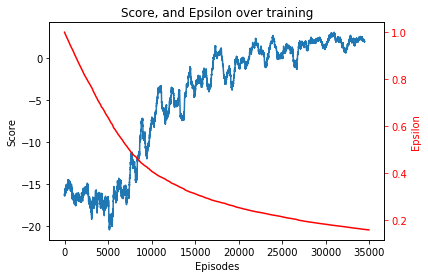

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
sc = smooth(scores, width=500)


fig, ax1 = plt.subplots()
ax1.plot(sc)
ax2 = ax1.twinx()
ax2.plot(epsilons, color='r')
ax1.set_ylabel('Score')
ax2.set_ylabel('Epsilon', color='r')
ax2.tick_params('y', colors='r')
plt.title("Score, and Epsilon over training")
ax1.set_xlabel("Episodes")
plt.figure()

In [18]:
from IPython import display
import time
g = Game(4, 4, 0.1, alea=True)

In [44]:
state = g.reset()
state = g._get_state()
print("state")
print("  ")
g.print()
done = False
time.sleep(5)
while not done:
    time.sleep(1)
    display.clear_output(wait=True)
    print(trainer.model.predict(np.array(g._get_state())))
    action = trainer.get_best_action(g._get_state(), rand=False)
    print(Game.ACTION_NAMES[action])
    next_state, reward, done, _ = g.move(action)
    g.print()
print(reward)

[[ 8.01647282  6.16151237  5.43019438  6.42914534]]
UP   
....
x..¤
....
..o.

10
